The code throughout this package was written in Julia v1.9. We begin by downloading dependices and loading the relevant modules.

In [1]:
# download dependencies
include("dependencies.jl");
# include files
include("main.jl");

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [2]:
# path for saving data and plots
data_path="Results/";
plot_path="Plots/";

Some notes about the code in the notebook:
- We plot make 2d plots and 3d plots in separate functions. The former are not so useful in this particular notebook since the orbit is non-equatorial, but they may be preferred when θi=π/2.
- The interactive 3d plots are html files. For some reason, the Plots.html(...) function saves broken html files when ran in jupyter notebook. To properly save the html files, the code should be run in a REPL.
- The run-times of the ODE solutions are those after compilation. That is, if you were to "run all" in this notebook for the first time, it would take longer than the sum of the reported times.

## Bound Kerr geodesics

We first compute a bound geodesic in Kerr, from which we will later build a semi-relativsitic gravitational waveform.

In [3]:
# specify params
a = 0.8; p = 6.5; e = 0.5; θi = π/6; M=1.0; m=1.0; τmax=3000.0; Δti=1.0; kerrReltol=1e-10; kerrAbstol=1e-10; saveat=0.5;

In [5]:
# solve geodesic equation, specifically built for Kerr
@time Kerr.KerrGeodesics.compute_kerr_geodesic(a, p, e, θi, τmax, Δti, kerrReltol, kerrAbstol, saveat, data_path=data_path)

ODE saved to: Results/ODE_sol_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.txt
  0.041832 seconds (157.06 k allocations: 35.732 MiB)


WebIO._IJuliaInit()

File saved: Plots/kerr_bound_3d_orbit_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.html


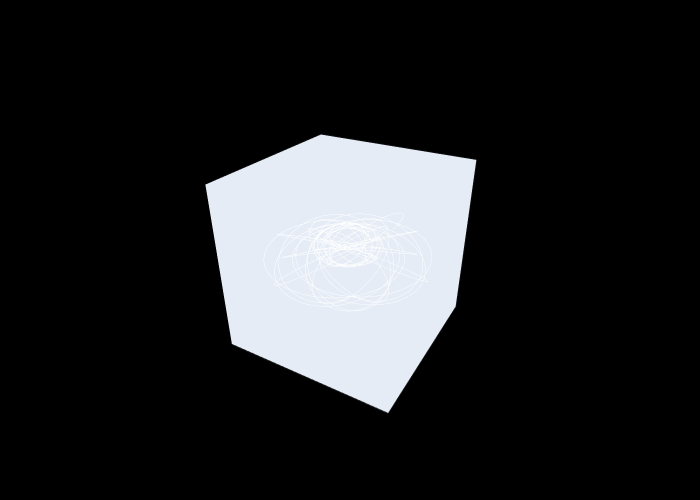

In [6]:
# ODE sol filename copied from output in cell above
kerr_ode_sol_fname = data_path * "ODE_sol_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(kerrReltol).txt"
# plot name
kerr_orbit_fname = "kerr_bound_3d_orbit_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(kerrReltol).html"
zlims = (-30, 30)    # zlims for plot
GRPlotLib.plot_orbit(kerr_ode_sol_fname, kerr_orbit_fname, zlims, plot_path=plot_path)

File saved: Plots/xy_orbit_a_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.png


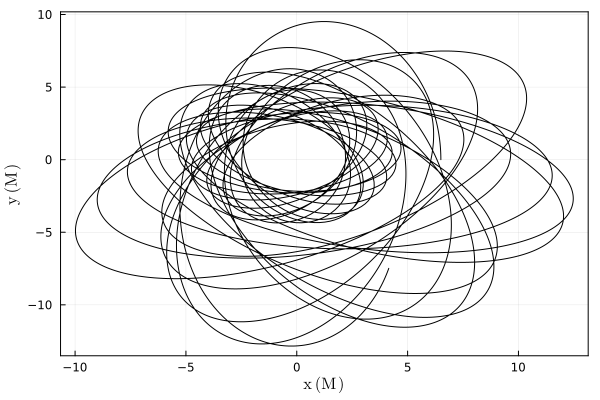

In [7]:
# plot orbit projected onto xy plane
xlims = (-11, 11)
ylims =  (-11, 11)
kerr_xy_fname = "xy_orbit_a_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(kerrReltol).png"
GRPlotLib.plot_xy_orbit(kerr_ode_sol_fname, kerr_xy_fname, xlims, ylims, plot_path=plot_path, color=:black, legend=:false, framestyle=:box)

## Geodesics in an arbitrary axisymmetric and stationary spacetime 

We will now compute a geodesic using a more arbitrary metric. This function evolves the geodesic equation by numerically evaluating the various derivatives of the metric to compute the Christoffel symbols. In this example, we will use the Kerr metric as our "generic" metric, so that the results can be compared with the functions specific to Kerr as a consistency check. The idea here is that you can replace the Kerr metric below with your favourite (stationary and axisymmetric) metric, which must also be a function of $t, r, θ, ϕ, a,$ and $M$.

In [8]:
Γαμν(t, r, θ, ϕ, a, M, α, μ, ν) = Kerr.KerrMetric.Γαμν(t, r, θ, ϕ, a, M, α, μ, ν);   # Christoffel symbols

# covariant metric components
g_tt(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.g_tt(t, r, θ, ϕ, a, M);
g_tϕ(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.g_tϕ(t, r, θ, ϕ, a, M);
g_rr(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.g_rr(t, r, θ, ϕ, a, M);
g_θθ(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.g_θθ(t, r, θ, ϕ, a, M);
g_ϕϕ(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.g_ϕϕ(t, r, θ, ϕ, a, M);
g_μν(t, r, θ, ϕ, a, M, μ, ν) = Kerr.KerrMetric.g_μν(t, r, θ, ϕ, a, M, μ, ν); 

# contravariant metric components
gTT(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.gTT(t, r, θ, ϕ, a, M);
gTΦ(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.gTΦ(t, r, θ, ϕ, a, M);
gRR(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.gRR(t, r, θ, ϕ, a, M);
gThTh(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.gThTh(t, r, θ, ϕ, a, M);
gΦΦ(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.gΦΦ(t, r, θ, ϕ, a, M);
ginv(t, r, θ, ϕ, a, M) = Kerr.KerrMetric.ginv(t, r, θ, ϕ, a, M);

In [9]:
# compute initial conditions
E, L, Q = Kerr.ConstantsOfMotion.ELQ(a, p, e, θi);
ra = p * M / (1 - e); ri = ra;
ics = Kerr.KerrGeodesics.boundKerr_ics(a, M, E, L, ri, θi, g_tt, g_tϕ, g_rr, g_θθ, g_ϕϕ);

In the above cell, we use a function specific to Kerr to compute the initial values of the constants of motions $E, L,$ and $Q$, and from them we compute the initial conditions. This is fine because our "generic" metric in this notebook is taken to be Kerr. For a general metric, another way we can choose values for $E$, and $L$ is via trial and error with the effective potential. That is, we can choose $E, L$, and $\theta$i, and plot $V_\text{eff}$ for different values of $r$. We can then see by inspection if bound orbits are permitted for our choice of $E, L$, and $\theta$i. If so, then we can use $V_\text{eff}$ to appropriately choose $r$i, and thereby complete the construction of our initial conditions. Otherwise we can try different values for $E, L$, and $\theta$i and repeat.

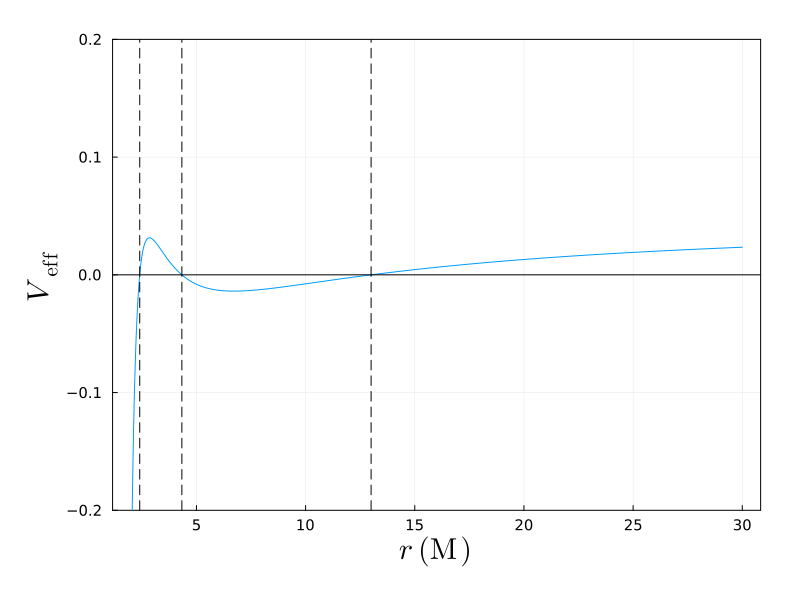

In [10]:
# plot Veff
M=1.0; m=1.0; ϕi = 0.0; ylims=(-0.2, 0.2);   # some plot kwargs
GRPlotLib.plot_vEff(θi, ϕi, a, M, E, L, m, g_tt, g_tϕ, g_ϕϕ, ylims)    

In [11]:
# now we can find the roots of Veff (if they exist) and appropriately prescribe one of these as our initial r, if bound orbits exist 
using Roots
f(r) = EffPotential.vEff(0., r, θi, ϕi, a, M, E, L, m, g_tt, g_tϕ, g_ϕϕ)
roots = find_zeros(f, 2M, 30M);
roots

3-element Vector{Float64}:
  2.403510385862886
  4.333333333333308
 12.999999999999975

In [12]:
# now construct inital conditions
ti = 0.0; ϕi = 0.0; ri=roots[3]; xi = [ti, ri, θi, ϕi]; uri = 0.0;
uti = NumericalGeodesics.tdot(xi..., a, M, E, L, g_ϕϕ, g_tϕ, g_tt); 
uϕi = NumericalGeodesics.ϕdot(xi..., a, M, E, L, g_ϕϕ, g_tϕ, g_tt);

# compute square of uθi, obtained from the Lagrangian
uθi² = (-1 - g_rr(xi..., a, M) * uri^2 - g_tt(xi..., a, M) * uti^2 - 2.0 * g_tϕ(xi..., a, M) * uti * uϕi - g_ϕϕ(xi..., a, M) * uϕi^2) / g_θθ(xi..., a, M)
uθi = abs(uθi²) <= 1e-14 ? 0. : sqrt(uθi²)  ? 0. : sqrt(uθi²)   # replace solutions close to zero by zero exactly
uxi = [uti, uri, uθi, uϕi]
ics1 = [uxi, xi];

In [13]:
# as a check, we should find that the initial conditions are the same because we are working solely in Kerr, and
# we chose ri=roots[3]=ra (apastron)
ics-ics1

2-element Vector{StaticArraysCore.SVector{4, Float64}}:
 [-2.220446049250313e-16, 0.0, 0.0, -1.457167719820518e-16]
 [0.0, 2.4868995751603507e-14, 0.0, 0.0]

Now, after constructing initial conditions one way or another, we are ready to solve the geodesic equation for a "generic" metric.

In [14]:
# lower tolerance
nReltol=1e-6; nAbstol=1e-6;

In [16]:
# solve geodesic equation for "generic" metric
@time NumericalGeodesics.compute_geodesic(g_tt, g_tϕ, g_rr, g_θθ, g_ϕϕ, ginv, ics, a, E, L, τmax, Δti, nReltol, nAbstol, saveat; data_path=data_path)

ODE saved to: Results/numerical_ODE_sol_a_0.8_E_0.949_L_1.61_tstep_0.5_T_3000.0_tol_1.0e-6.txt
  2.245694 seconds (41.90 M allocations: 667.946 MiB, 7.68% gc time)


File saved: Plots/n_3d_orbit_a_0.8_E_0.949_L_1.61_tstep_0.5_T_3000.0_tol_1.0e-6.html


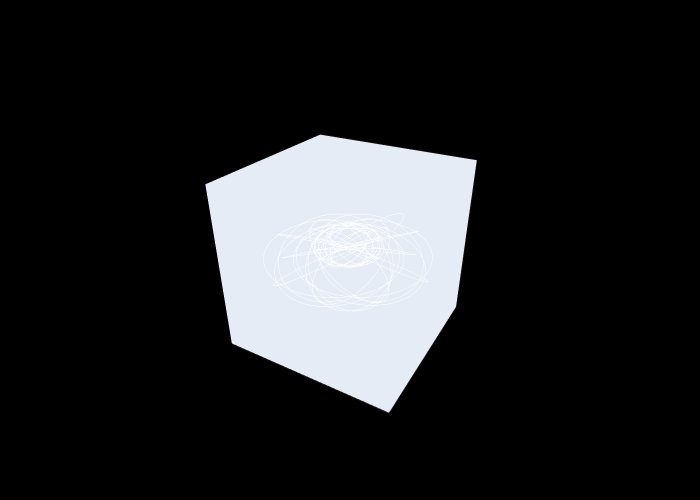

In [17]:
# plot 3d orbit
generic_ode_sol_fname = data_path * "numerical_ODE_sol_a_$(a)_E_$(round(E; digits=3))_L_$(round(L; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(nReltol).txt"
generic_orbit_fname = "n_3d_orbit_a_$(a)_E_$(round(E; digits=3))_L_$(round(L; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(nReltol).html"
zlims = (-30, 30)    # zlims for plot
GRPlotLib.plot_orbit(generic_ode_sol_fname, generic_orbit_fname, zlims, plot_path=plot_path)

File saved: Plots/xy_n_orbit_a_0.8_E_0.949_L_1.61_tstep_0.5_T_3000.0_tol_1.0e-6.png


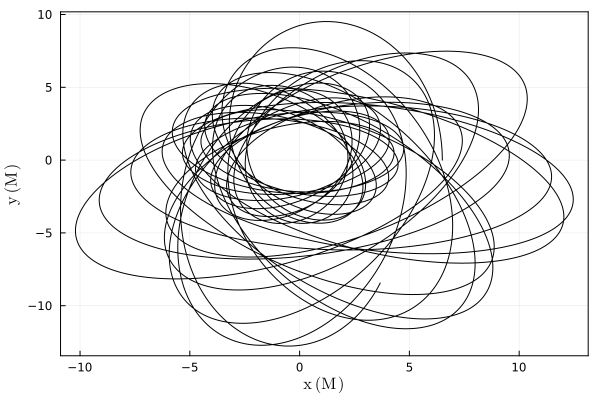

In [18]:
# plot orbit projected onto xy plane
generic_ode_sol_fname = data_path * "numerical_ODE_sol_a_$(a)_E_$(round(E; digits=3))_L_$(round(L; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(nReltol).txt"
generic_xy_fname = "xy_n_orbit_a_$(a)_E_$(round(E; digits=3))_L_$(round(L; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(nReltol).png"
xlims = (-11, 11)
ylims =  (-11, 11)
GRPlotLib.plot_xy_orbit(generic_ode_sol_fname, generic_xy_fname, xlims, ylims, plot_path=plot_path, color=:black, legend=:false, framestyle=:box)

As expected, this plot looks the same as the one above since our "generic" metric is still Kerr.

## Semi-relativistic kludge gravitational waveforms

We now compute semi-relativistic kludge waveforms, ignoring radiation reaction effects, using the method desrcibed in https://arxiv.org/abs/gr-qc/0607007. We again do this for both the kerr-specific solution to the geodesic equation, and the "generic" solution to demonstrate consistency.

In [19]:
# waveform filenames
kerr_waveform_fname = data_path * "kerr_SR_GW_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(kerrReltol).txt"
generic_waveform_fname= data_path * "generic_SR_GW_a_$(a)_E_$(round(E; digits=3))_L_$(round(L; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(nReltol).txt"

Θ=π/4; Φ=0.; obs_distance=1.;  # observer inclination, azimuth, and distance

# compute and save waveforms
KludgeWaveforms.SemiRelativistic.Kerr_waveform(kerr_ode_sol_fname, kerr_waveform_fname, Θ, Φ, obs_distance)
KludgeWaveforms.SemiRelativistic.waveform(generic_ode_sol_fname, generic_waveform_fname, Θ, Φ, obs_distance)

Waveform saved to: Results/kerr_SR_GW_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.txt
Waveform saved to: Results/generic_SR_GW_a_0.8_E_0.949_L_1.61_tstep_0.5_T_3000.0_tol_1.0e-6.txt


Kerr-specific


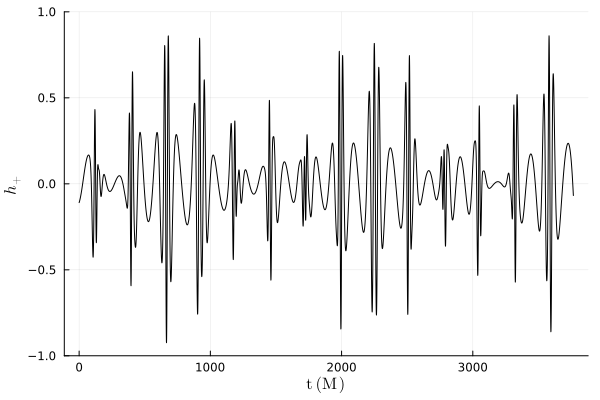

Generic metric


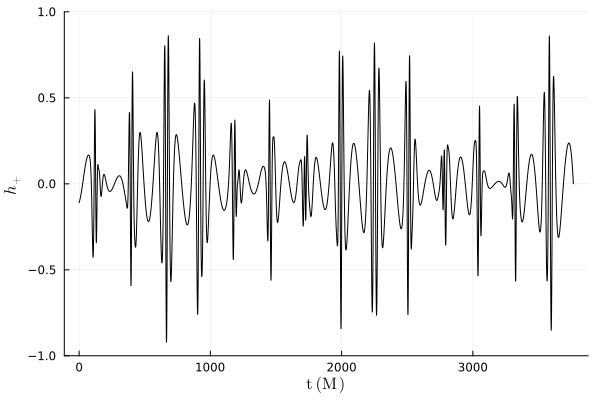

In [20]:
kerr_waveform_plot_fname="kerr_SR_WF_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(kerrReltol).png"
generic_waveform_plot_fname="generic_SR_WF_a_$(a)_E_$(round(E; digits=3))_L_$(round(L; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(nReltol).png"

ylims=(-1, 1)
# plots
println("Kerr-specific")
GRPlotLib.plot_waveform(kerr_waveform_fname, kerr_waveform_plot_fname; plot_path=plot_path, color=:black, legend=:false, ylims=ylims)
println("Generic metric")
GRPlotLib.plot_waveform(generic_waveform_fname, generic_waveform_plot_fname; plot_path=plot_path, color=:black, legend=:false, ylims=ylims)

And, as expected, the semi-relativstic waveforms look the same. Below, we produce a gif that shows the evolution of the waveform as the trajectory (projected onto the xy-plane) evolves.

117.381818 seconds (9.06 M allocations: 1.090 GiB, 0.26% gc time, 1.94% compilation time: 6% of which was recompilation)


[ Info: Saved animation to /Users/lennoxkeeble/Downloads/GRSuite/Plots/kerr_SR_WF_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.gif


Plots.AnimatedGif("/Users/lennoxkeeble/Downloads/GRSuite/Plots/kerr_SR_WF_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.gif")
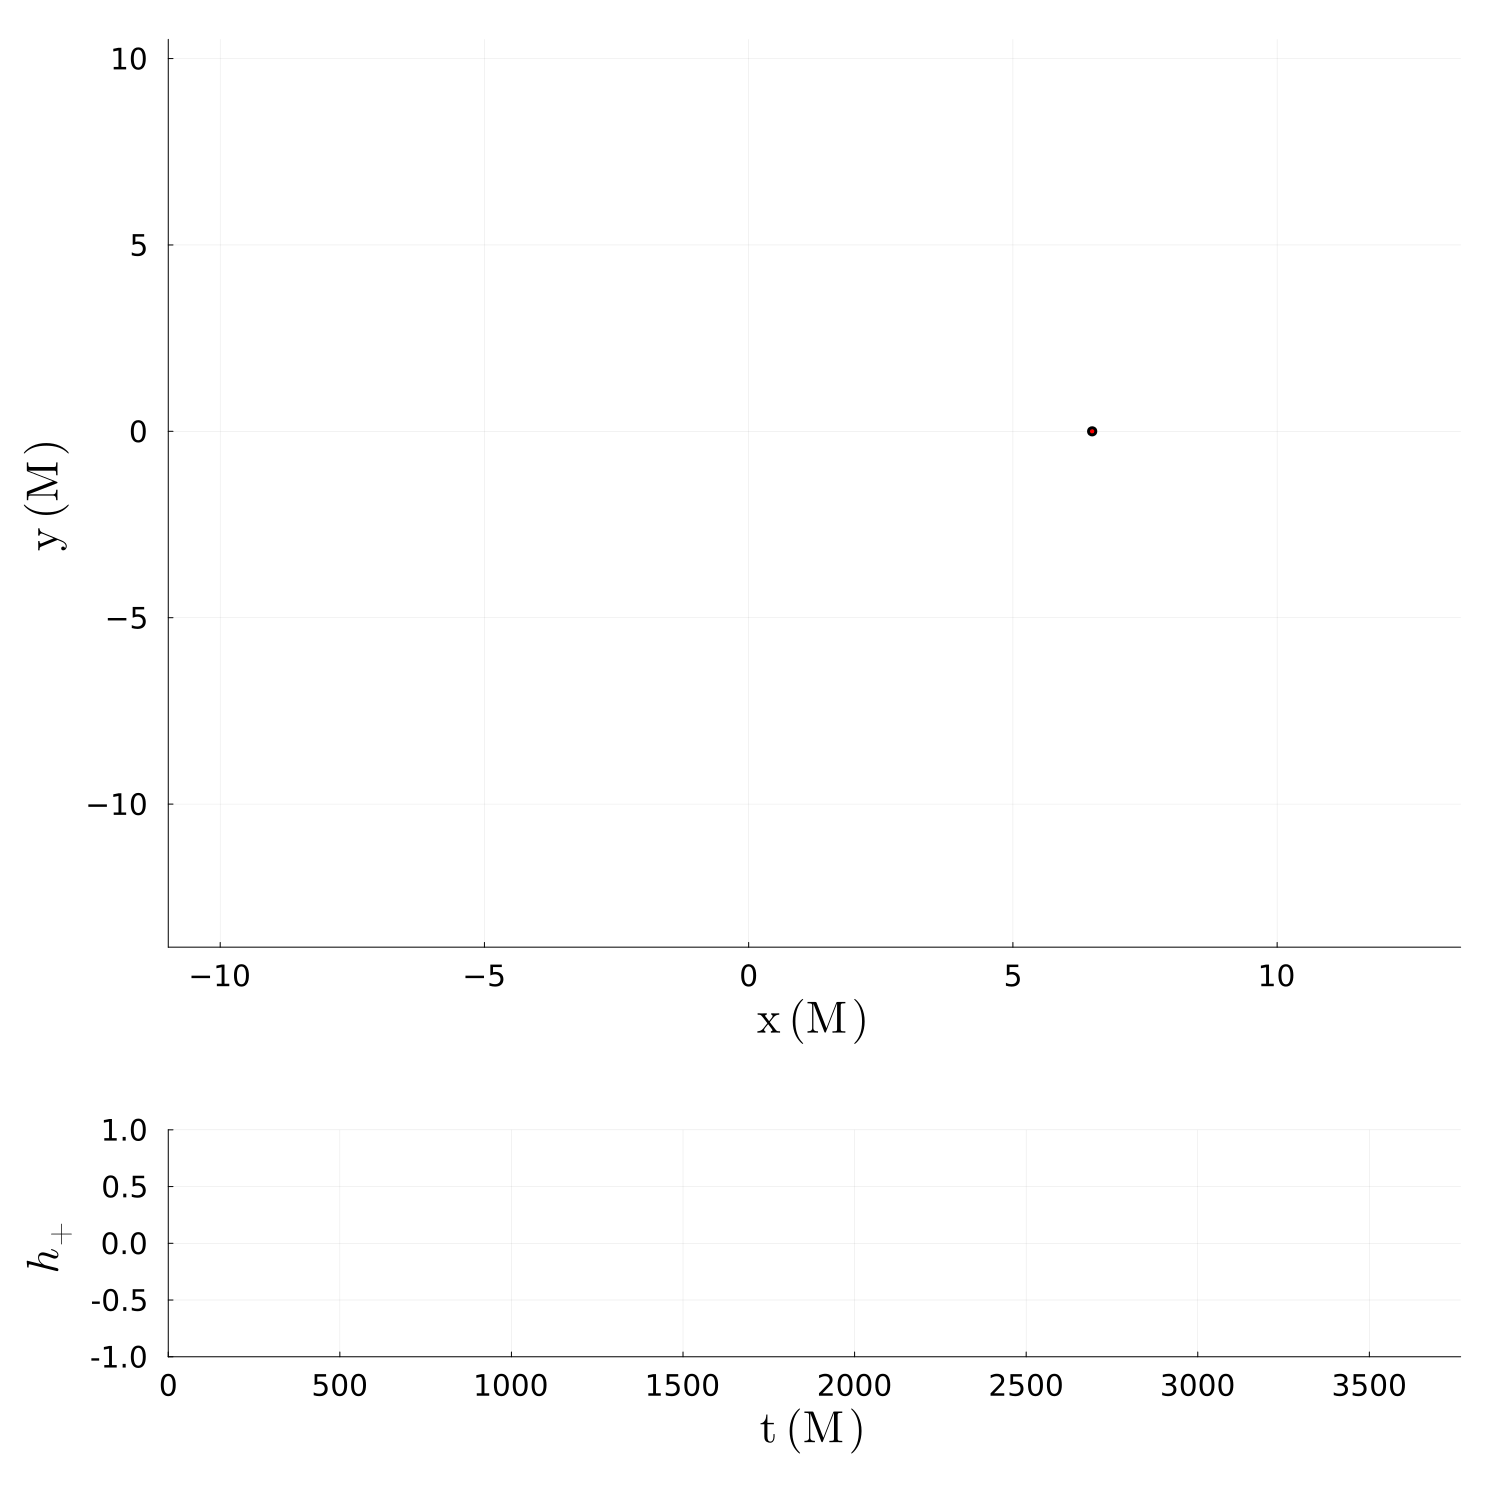

In [21]:
# produces gif following evolution of waveform with the particle trajectory projected onto the xy plane. 
# The .gif file is best opened in a web browser
gif_xy_fname = "kerr_SR_WF_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(kerrReltol).gif"
@time GRPlotLib.waveform_xy_orbit_gif(kerr_ode_sol_fname, kerr_waveform_fname, gif_xy_fname, plot_path=plot_path, tTicks=500, hlims=(-1, 1), hTicks=0.5, nFrames=10, fps=25)

For 3D orbits, we can plot a similar gif.

113.126773 seconds (8.91 M allocations: 1.063 GiB, 0.25% gc time, 1.05% compilation time: <1% of which was recompilation)


[ Info: Saved animation to /Users/lennoxkeeble/Downloads/GRSuite/Plots/kerr_SR_WF_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.gif


Plots.AnimatedGif("/Users/lennoxkeeble/Downloads/GRSuite/Plots/kerr_SR_WF_a_0.8_p_6.5_e_0.5_θi_0.524_tstep_0.5_T_3000.0_tol_1.0e-10.gif")
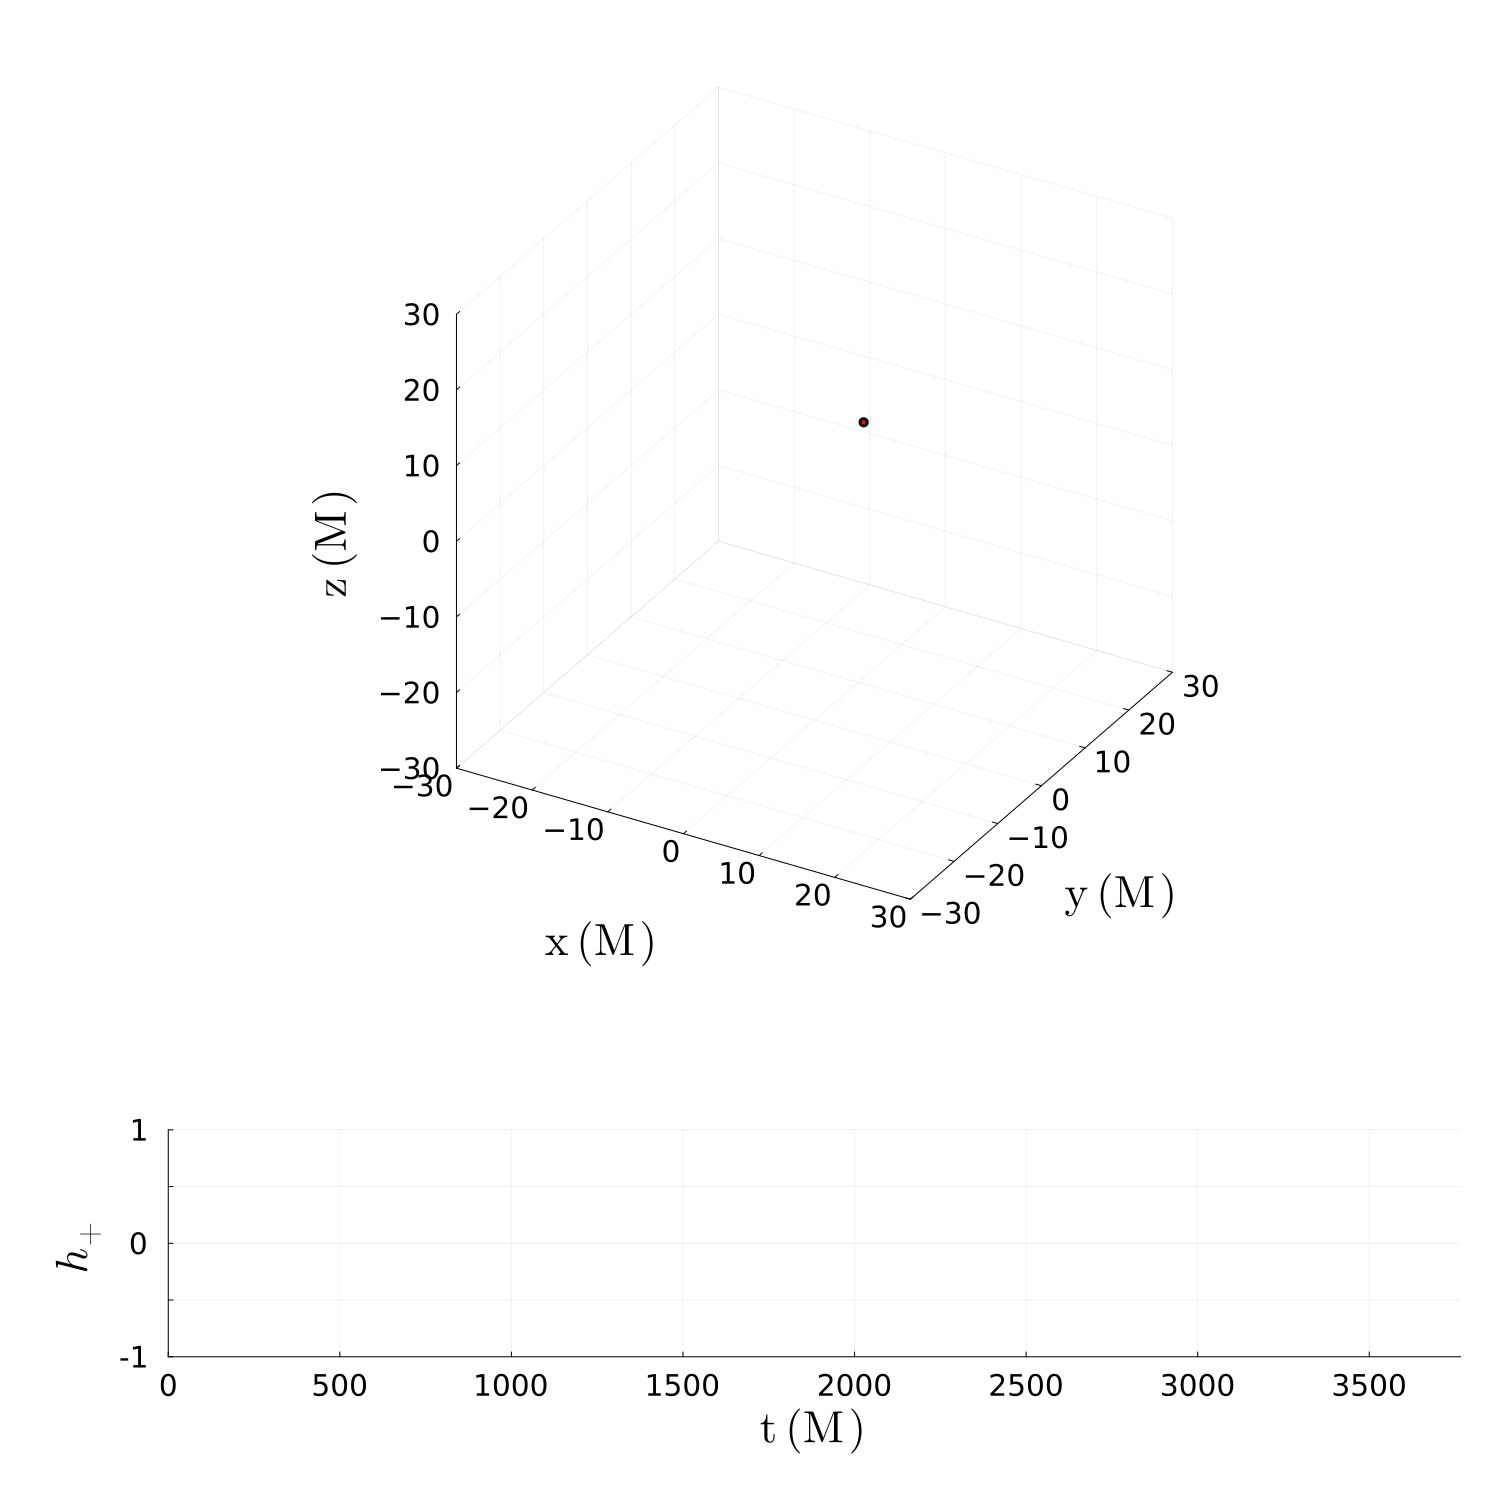

In [22]:
gif_orbit_fname = "kerr_SR_WF_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τmax)_tol_$(kerrReltol).gif"
@time GRPlotLib.waveform_orbit_gif(kerr_ode_sol_fname, kerr_waveform_fname, gif_orbit_fname; plot_path, tTicks=500, hlims=(-1, 1), hTicks=0.5, xlims=(-30, 30), ylims=(-30, 30), zlims=(-30, 30), nFrames=10, fps=25)

## Extreme-mass-ratio inspirals (EMRI)

EMRIs refer to the inspiral of a small compact object (SCO) as it orbits around a supermassive black hole (MBH), where the MBH's mass is roughly $10^4-10^6$ times larger than that of the SCO. The SCO inspirals due to so-called radiation reaction effects, wherein the small compact object affects the local geometry of MBH-dominated spacetime, and thus interacts with itself gravitatinoally. This self-interaction causes the SCO to lose energy and angular momentum, hence the inspiral. More accurately, the gravitational self-force causes fluxes of the SCO's energy, axial angular momentum, and associated Carter constant. Further, the affects of the SCO on the local geometry acts as a perturbation of the MBH's background spacetime. These perturbations are ripples in the fabric of spacetime, or, in other words, gravitational waves, which disperse to infinity and can be detected by far-away observers, as has been done successfully in experimental collaborations like the Laser Interferometer Gravitational-Wave Observatory (LIGO).

We now compute two EMRI trajectories, one of which evolves and plunges quickly, while the other is more slowly evolving but has a richer gravitational waveform. We use the kludge method described in https://arxiv.org/abs/1109.0572 to compute the gravitational self force of the inspiralling object along its trajectory. Currently, the computation of an EMRI is limited to Kerr.

In [24]:
# compute inspiral

τMax = 10000.0;   # evolve trajectory for up to τMax seconds (proper time)
nPoints = 20;    # update the self-acceleration every 20 points, i.e., each piecewise geodesic consists of 20 points
a=0.4; p=10.0; e=0.0; θi=π/2; M=1.0; m=10^-1;

@time SelfForce.compute_inspiral!(τMax, nPoints, M, m, a, p, e, θi,  Γαμν, g_μν, g_tt, g_tϕ, g_rr, g_θθ, g_ϕϕ, gTT, gTΦ, gRR, gThTh, gΦΦ, saveat, Δti, kerrReltol, kerrAbstol, data_path=data_path)

Integration terminated at t = 1423.7268724233068
Self-force file saved to: Results/aSF_a_0.4_p_10.0_e_0.0_θi_1.571_q_0.1_tstep_0.5_tol_1.0e-10.txt
ODE saved to: Results/EMRI_ODE_sol_a_0.4_p_10.0_e_0.0_θi_1.571_q_0.1_tstep_0.5_tol_1.0e-10.txt
 13.112794 seconds (345.21 M allocations: 6.342 GiB, 11.52% gc time)


File saved: Plots/EMRI_3d_orbit_a_0.4_p_10.0_e_0.0_θi_1.571_q_0.1_tstep_0.5_tol_1.0e-10.txt


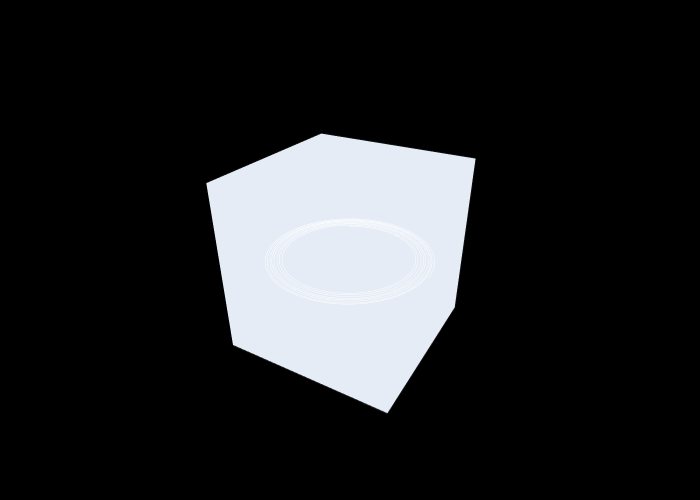

In [25]:
# plot orbit solution
EMRI_ode_sol_fname = "Results/EMRI_ODE_sol_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_q_$(m/M)_tstep_$(saveat)_tol_$(kerrReltol).txt"
EMRI_orbit_fname = "EMRI_3d_orbit_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_q_$(m/M)_tstep_$(saveat)_tol_$(kerrReltol).txt"
zlims = (-30, 30);
GRPlotLib.plot_orbit(EMRI_ode_sol_fname, EMRI_orbit_fname, zlims, plot_path=plot_path)

File saved: Plots/EMRI_xy_orbit__a_0.4_p_10.0_e_0.0_θi_1.571_q_0.1_tstep_0.5_tol_1.0e-10.png


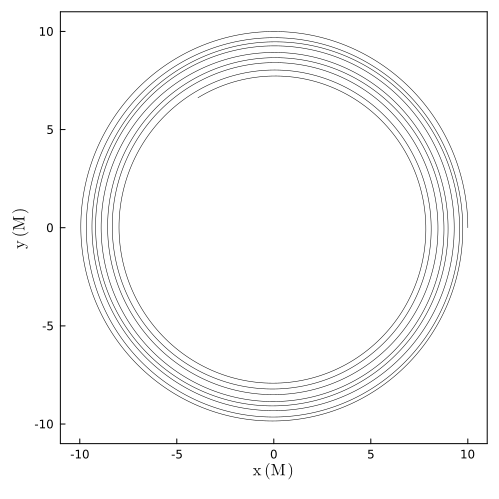

In [26]:
# plot x-y plane orbit
xlims = (-11, 11)
ylims =  (-11, 11)
EMRI_xy_fname = "EMRI_xy_orbit__a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_q_$(m/M)_tstep_$(saveat)_tol_$(kerrReltol).png"
GRPlotLib.plot_xy_orbit(EMRI_ode_sol_fname, EMRI_xy_fname, xlims, ylims, plot_path=plot_path,
xlims=(-11, 11), xticks=(-10:5:10, ["-10" "-5" "0" "5" "10"]),
ylims=(-11, 11), yticks=(-10:5:10, ["-10" "-5" "0" "5" "10"]),
size=(500, 500), color=:black, linewidth=0.5,
legend=false, grid=false, framestyle=:box)

In [27]:
# compute gravitational waveform
Θ=0.0; Φ=0.0; obs_distance=1.0;    # observer along the z-axis
waveform_fname = data_path * "kerr_RR_GW_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τMax)_tol_$(kerrReltol).txt"
# compute kerr waveform in the new kludge scheme
@time KludgeWaveforms.NewKludge.Kerr_waveform(a, M, m, EMRI_ode_sol_fname, waveform_fname, Θ, Φ, obs_distance)

 10.365936 seconds (73.20 M allocations: 7.189 GiB, 12.40% gc time, 33.51% compilation time)


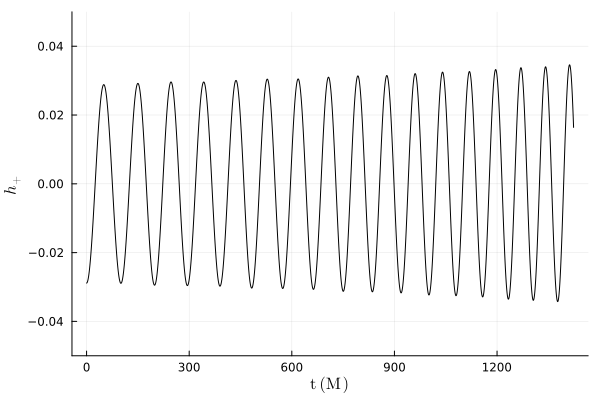

In [28]:
# plot gravitational waveform
waveform_plot_fname="kerr_RR_WF_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τMax)_tol_$(kerrReltol).png"
ylims=(-0.05, 0.05)
GRPlotLib.plot_waveform(waveform_fname, waveform_plot_fname; plot_path=plot_path, color=:black, legend=:false, ylims=ylims)

We now simulate the early stages of a more interesting inspiral, which has a richer gravitation waveform. 

In [29]:
# compute inspiral

τMax = 3000.0;   # evolve trajectory for up to τMax seconds (proper time)
nPoints = 20;    # update the self-acceleration every 20 points, i.e., each piecewise geodesic consists of 20 points
a=0.98; p=7.0; e=0.6; θi=π/2-(57.39 * π/180); M=1.0; m=10^-5;
# compute inspiral
@time SelfForce.compute_inspiral!(τMax, nPoints, M, m, a, p, e, θi,  Γαμν, g_μν, g_tt, g_tϕ, g_rr, g_θθ, g_ϕϕ, gTT, gTΦ, gRR, gThTh, gΦΦ, saveat, Δti, kerrReltol, kerrAbstol, data_path=data_path)

Self-force file saved to: Results/aSF_a_0.98_p_7.0_e_0.6_θi_0.569_q_1.0e-5_tstep_0.5_tol_1.0e-10.txt
ODE saved to: Results/EMRI_ODE_sol_a_0.98_p_7.0_e_0.6_θi_0.569_q_1.0e-5_tstep_0.5_tol_1.0e-10.txt
 33.479258 seconds (885.78 M allocations: 16.335 GiB, 11.57% gc time, 3.54% compilation time)


File saved: Plots/EMRI_3d_orbit_a_0.98_p_7.0_e_0.6_θi_0.569_q_1.0e-5_tstep_0.5_tol_1.0e-10.txt


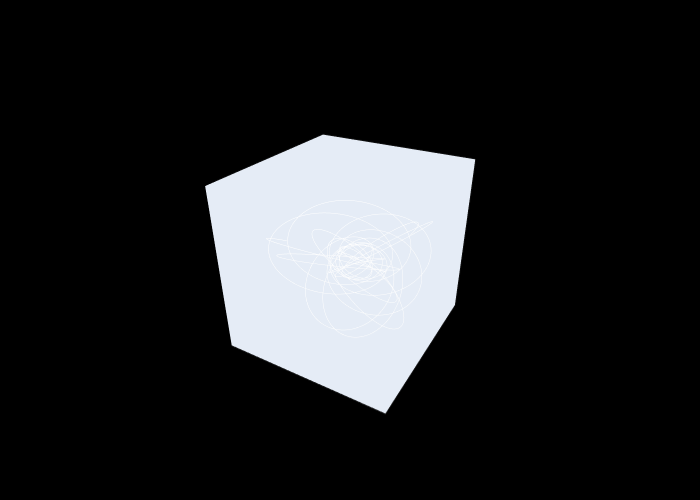

In [30]:
# plot orbit solution
EMRI_ode_sol_fname = "Results/EMRI_ODE_sol_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_q_$(m/M)_tstep_$(saveat)_tol_$(kerrReltol).txt"
EMRI_orbit_fname = "EMRI_3d_orbit_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_q_$(m/M)_tstep_$(saveat)_tol_$(kerrReltol).txt"
zlims = (-30, 30);
GRPlotLib.plot_orbit(EMRI_ode_sol_fname, EMRI_orbit_fname, zlims, plot_path=plot_path)

File saved: Plots/EMRI_xy_orbit__a_0.98_p_7.0_e_0.6_θi_0.569_q_1.0e-5_tstep_0.5_tol_1.0e-10.png


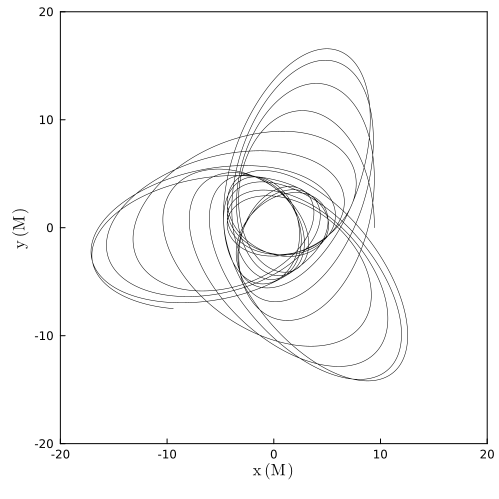

In [31]:
# plot orbit projected onto x-y plane
xlims = (-11, 11)
ylims =  (-11, 11)
EMRI_xy_fname = "EMRI_xy_orbit__a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_q_$(m/M)_tstep_$(saveat)_tol_$(kerrReltol).png"
GRPlotLib.plot_xy_orbit(EMRI_ode_sol_fname, EMRI_xy_fname, xlims, ylims, plot_path=plot_path,
xlims=(-20, 20), xticks=(-20:10:20, ["-20" "-10" "0" "10" "20"]),
ylims=(-20, 20), yticks=(-20:10:20, ["-20" "-10" "0" "10" "20"]),
size=(500, 500), color=:black, linewidth=0.5,
legend=false, grid=false, framestyle=:box)

In [32]:
# compute gravitational waveform
waveform_fname = data_path * "kerr_RR_GW_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τMax)_tol_$(kerrReltol).txt"
# compute kerr waveform in the new kludge scheme
@time KludgeWaveforms.NewKludge.Kerr_waveform(a, M, m, EMRI_ode_sol_fname, waveform_fname, Θ, Φ, obs_distance)

 53.057202 seconds (180.24 M allocations: 41.290 GiB, 13.42% gc time)


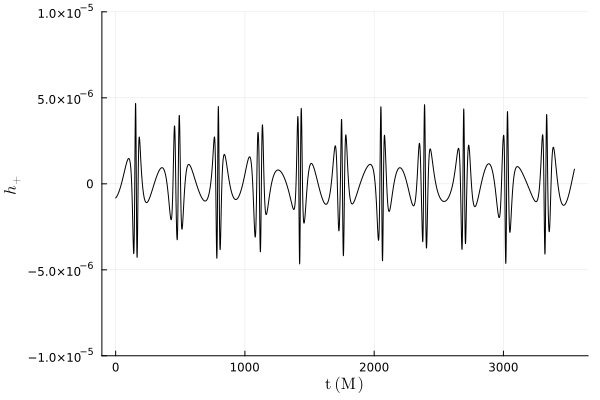

In [33]:
waveform_plot_fname="kerr_RR_WF_a_$(a)_p_$(p)_e_$(e)_θi_$(round(θi; digits=3))_tstep_$(saveat)_T_$(τMax)_tol_$(kerrReltol).png"
ylims=(-1e-5, 1e-5)
GRPlotLib.plot_waveform(waveform_fname, waveform_plot_fname; plot_path=plot_path, color=:black, legend=:false, ylims=ylims)